In [11]:
import cvxpy as cp
import numpy as np
import math
import pandas as pd
import itertools
import statsmodels.api as sm
import warnings
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import AdaBoostRegressor
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [57]:
home = raw_input("Which Home?")
file_path = 'Year1/Home' + home + '_yr1.csv'
print(file_path)

Which Home?10
Year1/Home10_yr1.csv


In [58]:
#print(file_path)
dft = pd.read_csv(file_path, names=['Actual'])
#print(dft.head())
intervals = pd.date_range(start='12/1/2014', end='12/1/2015', freq='15min', closed=None)[0:-1]
dft.insert(0, 'Timestamp', intervals)
dft = dft.set_index('Timestamp')

#print(dft.index)
#print(dft['2014-12-1 00:00:00':])

In [59]:
year = raw_input("Enter the Year:")
month = raw_input("Enter the Month:")
date = raw_input("Enter the Date:")
hour = raw_input("Enter the Hour:")
minute = raw_input("Enter the Minute:")
date1 = datetime(int(year), int(month), int(date), int(hour), int(minute) , 0)
print(date1)

Enter the Year:2015
Enter the Month:11
Enter the Date:1
Enter the Hour:0
Enter the Minute:0
2015-11-01 00:00:00


In [60]:
# Find the end interval after 7 days
print(date1)
end_dt = date1 + timedelta(days=7) - timedelta(minutes=15)
print(end_dt)

training_dataset = dft[: date1 - timedelta(minutes=15)]
dataset = dft[date1:end_dt]
y = dataset['Actual'].tolist()


2015-11-01 00:00:00
2015-11-07 23:45:00


In [61]:
#Offline Dynamic 
p = 0.1
a = 1
x = cp.Variable(672)
sum = 0

for i in range(1,672):
    sum += (cp.multiply(p,x[i]) + cp.maximum(0, y[i]-x[i]) + cp.abs(x[i] - x[i-1]))
    
objective = (cp.Minimize(sum))
constraints = [0 <= x]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
print(result)
# The optimal value for x is stored in `x.value`.
#print(x.value)

# The optimal Lagrange multiplier for a constraint is stored in
# `constraint.dual_value`.
#print(constraints[0].dual_value)

169.12796929856745


In [ ]:
#Offline static

p = 0.1
a = 1
# use the y as directly from the house values
y = dataset['Actual'].tolist()
x = cp.Variable(672)

equation = p*x + a*(cp.maximum(0,cp.exp(y-x)))
objective = cp.Minimize(cp.sum(equation))
constraints = [0 <= x]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
print(result)
# The optimal value for x is stored in `x.value`.
#print(x.value)
# The optimal Lagrange multiplier for a constraint is stored in
# `constraint.dual_value`.
#print(constraints[0].dual_value)

In [6]:
# Online Gradient Descent
a = 1
b = 1
p = 0.1
c = 0.01

def eta(i):
    return c/math.sqrt(i)

def df1(y , x1 , x2):
    if y > x1:
        if(x1 > x2):
            return p - a + b
        else:
            return p - a - b
    else:
        if(x1 > x2):
            return p + b
        else:
            return p - b
x = [0]
for i in range(1,672):
    x.append(x[i-1] - (0.055 * df1(y[i-1], x[i-1] , x[i-2])))
  
cost = 0
for i in range(0,len(x)):
    cost += p*x[i] + a*max(0, y[i] - x[i]) + b* abs(x[i] - x[i-1])
print(cost)

285.29625


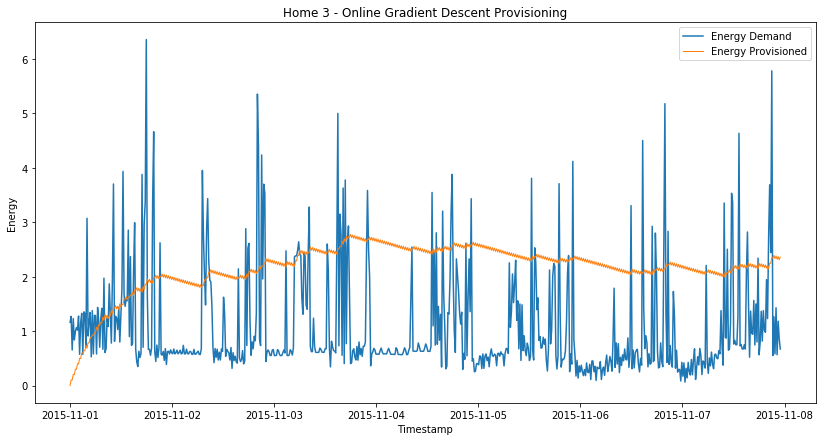

In [10]:
dur = [dt for dt in 
       pd.date_range(datetime(2015,11,1,0), datetime(2015, 11 , 7 , 23), 
       periods = 672).tolist()]
OD = pd.DataFrame({'Energy Demand': y }) 
OD['Energy Provisioned'] = x
OD['TimeStamp'] = dur
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 14
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size
plt.plot(OD['TimeStamp'], OD['Energy Demand'], label="Energy Demand")
plt.plot(OD['TimeStamp'], OD['Energy Provisioned'], linewidth=1, label="Energy Provisioned")
plt.title('Home 3 - Online Gradient Descent Provisioning')
plt.xlabel('Timestamp')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [ ]:
# Predictions for RHC and CHC ahead
# ARIMA algorithm starts
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [ ]:
# find the optimal set of parameters that yields the best performance for our model
# Choose the one with the least resulting AIC value
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(training_dataset,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
pdq = [1, 1, 0, 1, 1, 1, 1]
#print(pdq)
mod = sm.tsa.statespace.SARIMAX(training_dataset,
                                order=(pdq[1], pdq[2], pdq[3]),
                                seasonal_order=(pdq[4], pdq[5], pdq[6], 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

In [ ]:
# Forecasting
pred = results.get_prediction(start=date1, end=end_dt+timedelta(hours=1)+timedelta(minutes=15), dynamic=False)
arima_pred_list = pred.predicted_mean.values.tolist()
y_pred_arima = np.asarray(arima_pred_list)
df_forecasted = pred.predicted_mean[:672]
df_truth = dataset['Actual']
print("Mean absolute error LR: %.9f"
      % mean_absolute_error(df_truth,df_forecasted))

In [ ]:
print(file_path)
df = pd.read_csv(file_path, names=['Consumption'])
#print(df)
def datetime_range(start, end, delta):
    end += 4*delta
    current = start
    while current < end:
        yield current
        current += delta

dts = [dt for dt in 
       datetime_range(datetime(2014, 12, 1, 0), datetime(2015, 11 , 30 , 23), 
       timedelta(minutes=15))]
df['date/time'] = dts

In [ ]:
for i, row in df.iterrows():
#handling seasons
    df.at[i, 'Year'] = row[1].year
    df.at[i, 'Date'] = row[1].day
    df.at[i, 'Month'] = row[1].month
    df.at[i, 'Hour'] = row[1].hour
    df.at[i, 'Minute'] = row[1].minute
    if row[1].month in range(1,4) :
        df.at[i, 'Summer'] = 1
    elif row[1].month in range(4,7):
        df.at[i, 'Spring'] = 1
    elif row[1].month in range(7,10):
        df.at[i, 'Fall'] = 1
    elif row[1].month in range(10,13):
        df.at[i, 'Winter'] = 1
        
#handling peak hours   
    if row[1].hour in [0,1,2,3,4,5,6,7,20,21,22,23]:
        df.at[i, 'Peak Hour'] = 1
    else:
        df.at[i, 'Peak Hour'] = 0
        
#handling holidays & weekends
    if row[1].weekday() in [5,6] :
        df.at[i, 'Holiday'] = 1
    elif row[1].month == 10 and row[1].day == 2:
        df.at[i, 'Holiday'] = 1
    elif row[1].month == 1 and row[1].day == 26:
        df.at[i, 'Holiday'] = 1
    else:
        df.at[i, 'Holiday'] = 0

df['Spring'].fillna(0,inplace=True)
df['Fall'].fillna(0,inplace=True)
df['Summer'].fillna(0,inplace=True)
df['Winter'].fillna(0,inplace=True)

In [ ]:
for i, row in df.iterrows():
    if row[1] == date1:
        break
x_train = df[['Year','Date','Month','Hour','Minute','Summer','Winter', 'Fall','Spring' , 'Holiday', 'Peak Hour']][:i]
y_train = df[['Consumption']][:i]
x_test = df[['Year','Date','Month','Hour','Minute','Summer','Winter', 'Fall','Spring' , 'Holiday', 'Peak Hour']] [i:677+i]
y_test = df[['Consumption']][i:677+i]

In [ ]:
y_pred_arima = np.loadtxt("y_arima_pred_house1.csv")
print(len(y_pred_arima))
print(type(y_pred_arima))
y_pred_adaboost = np.loadtxt("y_adaboost_pred_house1.csv")
print(len(y_pred_adaboost))
print(type(y_pred_adaboost))

In [ ]:
# RHC with Arima predictions
p = 0.1
a = 1
w = 10
X_1 = [0]

for t in range(1,672):
    y = y_pred_arima[t:t+w]
    x = cp.Variable(w)
    sum = 0
    for i in range(0,w):
        sum += (cp.multiply(p,x[i]) + cp.maximum(0, y[i]-x[i]) + cp.abs(x[i] - x[i-1]))
    
    objective = (cp.Minimize(sum))
    constraints = [0 <= x]
    prob = cp.Problem(objective, constraints)

    # The optimal objective value is returned by `prob.solve()`.
    result = prob.solve()
    #print(result)
    # The optimal value for x is stored in `x.value`.
    X_1.append(x.value[0])
print(len(X_1))

In [ ]:
rhc_cost_arima = 0
for i in range(1,len(X_1)):
    rhc_cost_arima += p*X_1[i] + a*max(0, y_pred_arima[i] - X_1[i]) + b*abs(X_1[i] - X_1[i-1])
print(rhc_cost_arima)

In [ ]:
# RHC with AdaBoost predictions
p = 0.1
a = 1
w = 10
X_2 = [0]

for t in range(1,672):
    y = y_pred_adaboost[t:t+w]
    x = cp.Variable(w)
    sum = 0
    for i in range(0,w):
        sum += (cp.multiply(p,x[i]) + cp.maximum(0, y[i]-x[i]) + cp.abs(x[i] - x[i-1]))
    
    objective = (cp.Minimize(sum))
    constraints = [0 <= x]
    prob = cp.Problem(objective, constraints)

    # The optimal objective value is returned by `prob.solve()`.
    result = prob.solve()
    #print(result)
    # The optimal value for x is stored in `x.value`.
    X_2.append(x.value[0])
    
    # The optimal Lagrange multiplier for a constraint is stored in
    # `constraint.dual_value`.
    #print(constraints[0].dual_value)
print(len(X_2))
print(X_2)

In [ ]:
rhc_cost_adb = 0
for i in range(1,len(X_2)):
    rhc_cost_adb += p*X_2[i] + a*max(0, y_pred_adaboost[i] - X_2[i]) + b*abs(X_2[i] - X_2[i-1])
print(rhc_cost_adb)

In [ ]:
# CHC with Arima predictions
p = 0.1
a = 1
w = 10
v = 5
X_3 = [0]

for t in range(1,672):
    y = y_pred_arima[t:t+w]
    x = cp.Variable(w)
    sum = 0
    for i in range(0,w):
        sum += (cp.multiply(p,x[i]) + cp.maximum(0, y[i]-x[i]) + cp.abs(x[i] - x[i-1]))
    
    objective = (cp.Minimize(sum))
    constraints = [0 <= x]
    prob = cp.Problem(objective, constraints)

    # The optimal objective value is returned by `prob.solve()`.
    result = prob.solve()
    #print(result)
    # The optimal value for x is stored in `x.value`.
    avg = 0
    for i in range(0,v):
        avg += x.value[i]/v
    X_3.append(avg)
print(len(X_3))

In [ ]:
chc_cost_arima = 0
for i in range(1,len(X_3)):
    chc_cost_arima += p*X_3[i] + a*max(0, y_pred_arima[i] - X_3[i]) + b*abs(X_3[i] - X_3[i-1])
print(chc_cost_arima)

In [ ]:
# CHC with AdaBoost predictions
p = 0.1
a = 1
w = 10
v = 5
X_4 = [0]

for t in range(1,672):
    y = y_pred_adaboost[t:t+w]
    x = cp.Variable(w)
    sum = 0
    for i in range(0,w):
        sum += (cp.multiply(p,x[i]) + cp.maximum(0, y[i]-x[i]) + cp.abs(x[i] - x[i-1]))
    
    objective = (cp.Minimize(sum))
    constraints = [0 <= x]
    prob = cp.Problem(objective, constraints)

    # The optimal objective value is returned by `prob.solve()`.
    result = prob.solve()
    #print(result)
    # The optimal value for x is stored in `x.value`.
    avg = 0
    for i in range(0,v):
        avg += x.value[i]/v
    X_4.append(avg)
    
    # The optimal Lagrange multiplier for a constraint is stored in
    # `constraint.dual_value`.
    #print(constraints[0].dual_value)
print(len(X_4))
print(X_4)

In [ ]:
chc_cost_adb = 0
for i in range(1,len(X_4)):
    chc_cost_adb += p*X_4[i] + a*max(0, y_pred_adaboost[i] - X_4[i]) + b*abs(X_4[i] - X_4[i-1])
print(chc_cost_adb)